Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import re
import string
import csv
import requests
from io import StringIO
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

2025-04-13 18:21:09.247132: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 18:21:09.251999: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 18:21:09.261420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744543269.276133  812428 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744543269.280485  812428 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744543269.292748  812428 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/arch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/arch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading Dataset

In [3]:
app_reviews_df = pd.read_csv('dataset.csv')

app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3c274eb3-4de3-41fd-85be-85fb22a55c8b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mengapa sangat sulit mengganti KTP padahal sem...,2,351,2.77.0,2025-03-29 23:56:30,NaN,NaN,2.77.0
1,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Emang aplikasi BUSUK.Saya transaksi sudah terj...,1,1251,2.77.0,2025-03-28 01:49:41,"Hi Kak, maaf udah bikin kamu ga tenang. Terkai...",2025-03-12 01:25:35,2.77.0
2,c1f3e4db-e86a-45b1-a66f-ae922ca02337,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sudah beberapa tahun menjadi user dana, dan ma...",5,83,2.77.0,2025-04-11 10:24:08,NaN,NaN,2.77.0
3,b7e92383-8d53-489b-b08a-6e0c1d450470,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,cukup membantu.. tinggal keamanannya saja yg d...,5,85,2.77.0,2025-04-11 12:55:26,"Hi kak, kami paham apa yg kamu rasakan.Kami in...",2025-04-13 09:31:25,2.77.0
4,d0a80d29-37a0-483d-9d8b-e0fe06535ad8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kurangin bintang nya ga bisa di buka kalo jari...,2,63,2.77.0,2025-04-08 17:18:29,NaN,NaN,2.77.0


In [4]:
# Hapus kolom tidak relevan untuk analisis sentimen
columns_to_drop = [
    'reviewId', 'userName', 'userImage', 'reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion'
]

app_reviews_df = app_reviews_df.drop(columns=columns_to_drop)

app_reviews_df.head()

,content,score,thumbsUpCount,at
0,mengapa sangat sulit mengganti KTP padahal sem...,2,351,2025-03-29 23:56:30
1,Emang aplikasi BUSUK.Saya transaksi sudah terj...,1,1251,2025-03-28 01:49:41
2,"Sudah beberapa tahun menjadi user dana, dan ma...",5,83,2025-04-11 10:24:08
3,cukup membantu.. tinggal keamanannya saja yg d...,5,85,2025-04-11 12:55:26
4,kurangin bintang nya ga bisa di buka kalo jari...,2,63,2025-04-08 17:18:29


In [5]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85500 entries, 0 to 85499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        85500 non-null  object
 1   score          85500 non-null  int64 
 2   thumbsUpCount  85500 non-null  int64 
 3   at             85500 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


In [6]:
# Cek jumlah duplikat
print(app_reviews_df.duplicated().sum())

0


In [7]:
# Cek missing value
print(app_reviews_df.isnull().sum())

content          0
score            0
thumbsUpCount    0
at               0
dtype: int64


Prepocessing Text

In [8]:
def cleaningText(text):
    emoticon_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoticon_pattern.sub(r'', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

In [9]:
def casefoldingText(text):
    return text.lower()

In [10]:
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", 
    "bgt": "banget", "maks": "maksimal", "yg": "yang", "dgn": "dengan", "utk": "untuk", "dr": "dari", 
    "kpd": "kepada", "trs": "terus", "tdk": "tidak", "tapi": "tetapi", "sdh": "sudah", "blm": "belum", 
    "dll": "dan lain-lain", "dsb": "dan sebagainya", "kl": "kalau", "klo": "kalau", "knp": "kenapa",
    "kok": "kenapa", "gue": "saya", "gw": "saya", "lo": "kamu", "lu": "kamu", "jd": "jadi", 
    "jg": "juga", "udh": "sudah", "lgsg": "langsung", "bkn": "bukan", "skrg": "sekarang", 
    "aja": "saja", "sih": "", "nih": "ini", "tu": "itu", "bgtu": "begitu", "emg": "memang", 
    "sm": "sama", "kyk": "seperti", "kek": "seperti", "pdhl": "padahal", "btw": "ngomong-ngomong", 
    "pls": "tolong", "thx": "terima kasih", "thankyou": "terima kasih", "thank": "terima kasih", 
    "TQ": "terima kasih", "omg": "ya ampun", "wkwk": "", "hehe": "", "huhu": "", "astaga": "wah", 
    "anjir": "", "wow": "kagum", "bg": "abang", "kak": "kakak", "sis": "saudari", "bro": "saudara", 
    "gan": "juragan", "min": "admin", "tp": "tapi", "gk": "tidak", "bagu": "bagus", "sy": "saya", 
    "g": "tidak", "ga": "tidak", "gx": "tidak", "ngga": "tidak", "nggak": "tidak", "liat": "lihat",
    "jwb": "jawab", "mnt": "minta", "dpt": "dapat", "plg": "paling", "jgn": "jangan", "lbh": "lebih",
    "byk": "banyak", "gpp": "tidak apa-apa", "bs": "bisa", "krn": "karena", "bnr": "benar", 
    "slh": "salah", "mw": "mau", "trm": "terima", "brg": "barang", "kmrn": "kemarin"
}

def fix_slangwords(text):
    return ' '.join([slangwords.get(word.lower(), word) for word in text.split()])

In [11]:
def tokenizingText(text):
    return word_tokenize(text)

In [12]:
def filteringText(text_tokens):
    factory = StopWordRemoverFactory()
    stopword_id = set(factory.get_stop_words())
    stopword_en = set(stopwords.words('english'))
    custom_stop = {'iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy",
        "dana", "aplikasi", "toko", "pedia", "tolong", "gratis", "ongkir", 
        "belanja", "barang", "kalo", "udah", 'beli', 'jual', 'ulasan', 'review', 'pesan', 'chat', 
        'akun', 'produk', 'harga', 'promo', 'diskon', 'pembayaran', 'transfer', 'kirim', 'kurir', 
        'sampai', 'terima', 'pesanan', 'transaksi', 'rekomendasi', 'fitur', 'layanan', 'bantuan', 
        'cs', 'admin', 'seller', 'pembeli', 'customer', 'bagus', 'baik', 'buruk', 'cepat', 'lama', 
        'murah', 'mahal', 'sesuai', 'sangat', 'lebih', 'kurang', 'cuma', 'hanya', 'banget', 'kali', 
        'deh', 'dong', 'aja', 'satu', 'dua', 'tiga', 'ribu', 'juta', 'pcs', 'buah', 'yg', 'utk', 
        'dgn', 'dll', 'dsb', 'jg', 'bgt', 'pake', 'pakai', 'pengguna', 'penjual', 'selalu', 'sering', 
        'kadang', 'coba', 'lihat', 'cek', 'beritahu', 'informasi', 'memberikan', 'mendapatkan', 
        'menurut', 'rasa', 'merasa', 'buat', 'agar', 'supaya', 'ingin', 'mau', 'akan', 'sedang', 
        'telah', 'sudah', 'belum', 'masih', 'sini', 'situ', 'sana', 'mari', 'ayo', 'kenapa', 
        'bagaimana', 'dimana', 'kapan', 'siapa', 'apa', 'hai', 'halo', 'hei', 'nomor', 'tanggal', 
        'bulan', 'tahun'
    }
    all_stopwords = stopword_id.union(stopword_en).union(custom_stop)
    return [word for word in text_tokens if word not in all_stopwords]

In [13]:
def stemmingText(text):
    stemmer = StemmerFactory().create_stemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [14]:
def toSentence(tokens):
    return ' '.join(tokens)

In [15]:
app_reviews_df['text_clean'] = app_reviews_df['content'].apply(cleaningText)
app_reviews_df['text_casefold'] = app_reviews_df['text_clean'].apply(casefoldingText)
app_reviews_df['text_slang'] = app_reviews_df['text_casefold'].apply(fix_slangwords)
app_reviews_df['text_tokens'] = app_reviews_df['text_slang'].apply(tokenizingText)
app_reviews_df['text_filtered'] = app_reviews_df['text_tokens'].apply(filteringText)
app_reviews_df['text_stemmed'] = app_reviews_df['text_filtered'].apply(toSentence)

Pelabelan

In [16]:
lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text))
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = {
    "buruk": 3,
    "jelek": 3,
    "error": 3,
    "gagal": 3,
    "lemot": 3,
    "parah": 3,
    "susah": 2,
    "mengecewakan": 3,
    "bego": 2,
    "kecewa": 3,
    "lambat": 2,
    "tidak": 3,
    "tidak bisa": 3,
    "sulit": 2,
    "pusing": 2,
    "harusnya": 2,
    "salah": 3,
    "tidak puas": 3,
    "rusak": 3,
    "bermasalah": 3,
    "gangguan": 3,
    "mengganggu": 2,
    "bocor": 2,
    "sembrono": 2,
    "tidak memuaskan": 3,
    "kerusakan": 3,
    "gagal paham": 3,
    "jelek banget": 3,
    "sembrono": 2,
    "boros": 2,
    "kerja lambat": 2,
    "ribet": 2,
    "stres": 2,
    "buntu": 2,
    "tumpul": 2,
    "berantakan": 3,
    "penipuan": 3,
    "menyebalkan": 3,
    "merugikan": 3,
    "menipu": 3,
    "bohong": 3,
    "kacau": 3,
    "terlalu mahal": 2,
    "tidak efektif": 3,
    "kosong": 3,
    "hilang": 3,
    "dungu": 2,
    "lemot banget": 3,
    "lambat banget": 3,
    "jelek sekali": 3,
    "membosankan": 3,
    "bikin pusing": 3,
    "tidak bermanfaat": 3,
    "kesalahan": 3,
    "ga bisa": 3,
    "gagal terus": 3,
    "pecah": 3,
    "sial": 3,
    "bejat": 2,
    "pecundang": 2,
    "lembek": 2,
    "bersalah": 3,
    "jelek banget": 3,
    "mengecewakan banget": 3,
    "rusak parah": 3,
    "ngaco": 2,
    "ga nyambung": 2,
    "ga jelas": 2,
    "parah banget": 3,
    "seret": 2,
    "menyusahkan": 3,
    "terlalu mahal": 3,
    "tidak berguna": 3,
    "gagal total": 3,
    "cetek": 2,
    "rusak banget": 3,
    "miskin fitur": 2,
    "kurang bagus": 2,
    "ga efektif": 3,
    "terlalu lama": 3,
    "biasa aja": 2,
    "lemot parah": 3,
    "kebingungan": 3,
    "pernah error": 3,
    "terlalu sulit": 3,
    "terlalu banyak iklan": 2,
    "tidak sinkron": 2,
    "buruk banget": 3,
    "ga berguna": 3,
    "kurang responsif": 2,
    "basi": 2,
    "banyak bug": 3
}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text))
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])     

In [17]:
def label_sentiment(text):
    score = 0
    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score -= lexicon_negative[word]
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'
    
app_reviews_df['label'] = app_reviews_df['text_stemmed'].apply(label_sentiment)

In [18]:
app_reviews_df.head()

,content,score,thumbsUpCount,at,text_clean,text_casefold,text_slang,text_tokens,text_filtered,text_stemmed,label
0,mengapa sangat sulit mengganti KTP padahal sem...,2,351,2025-03-29 23:56:30,mengapa sangat sulit mengganti KTP padahal sem...,mengapa sangat sulit mengganti ktp padahal sem...,mengapa sangat sulit mengganti ktp padahal sem...,"[mengapa, sangat, sulit, mengganti, ktp, padah...","[sulit, mengganti, ktp, padahal, semua, persya...",sulit mengganti ktp padahal semua persyaratan ...,positif
1,Emang aplikasi BUSUK.Saya transaksi sudah terj...,1,1251,2025-03-28 01:49:41,Emang aplikasi BUSUKSaya transaksi sudah terja...,emang aplikasi busuksaya transaksi sudah terja...,emang aplikasi busuksaya transaksi sudah terja...,"[emang, aplikasi, busuksaya, transaksi, sudah,...","[emang, busuksaya, terjadi, berhasil, bukti, b...",emang busuksaya terjadi berhasil bukti berhasi...,positif
2,"Sudah beberapa tahun menjadi user dana, dan ma...",5,83,2025-04-11 10:24:08,Sudah beberapa tahun menjadi user dana dan mas...,sudah beberapa tahun menjadi user dana dan mas...,sudah beberapa tahun menjadi user dana dan mas...,"[sudah, beberapa, tahun, menjadi, user, dana, ...","[beberapa, menjadi, user, jadi, salah, ewallet...",beberapa menjadi user jadi salah ewallet favor...,positif
3,cukup membantu.. tinggal keamanannya saja yg d...,5,85,2025-04-11 12:55:26,cukup membantu tinggal keamanannya saja yg di ...,cukup membantu tinggal keamanannya saja yg di ...,cukup membantu tinggal keamanannya saja yang d...,"[cukup, membantu, tinggal, keamanannya, saja, ...","[cukup, membantu, tinggal, keamanannya, tingka...",cukup membantu tinggal keamanannya tingkatkan ...,positif
4,kurangin bintang nya ga bisa di buka kalo jari...,2,63,2025-04-08 17:18:29,kurangin bintang nya ga bisa di buka kalo jari...,kurangin bintang nya ga bisa di buka kalo jari...,kurangin bintang nya tidak bisa di buka kalo j...,"[kurangin, bintang, nya, tidak, bisa, di, buka...","[kurangin, bintang, buka, jaringan, data, mah,...",kurangin bintang buka jaringan data mah wifi m...,positif


Ekplorasi Label

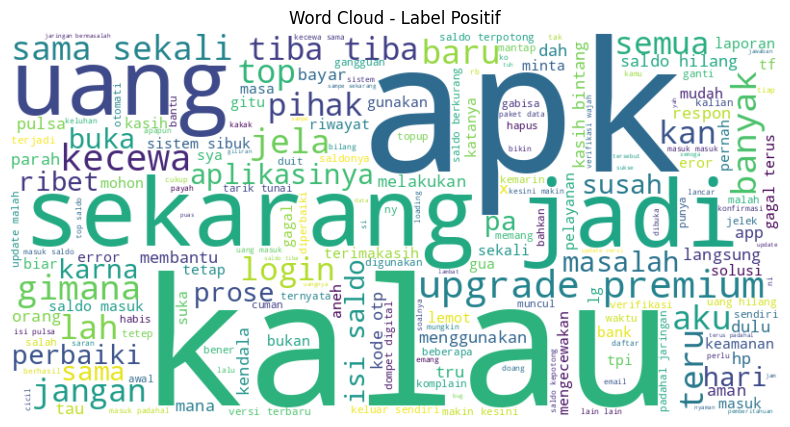

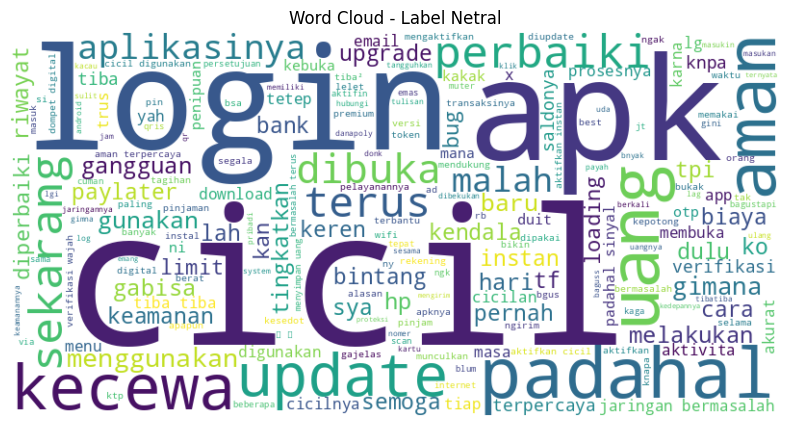

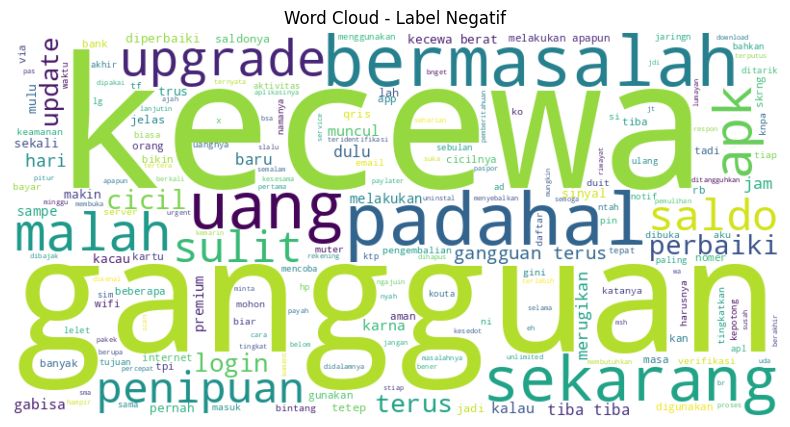

In [20]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_reviews = app_reviews_df[app_reviews_df['label'] == 'positif']['text_stemmed']
neutral_reviews = app_reviews_df[app_reviews_df['label'] == 'netral']['text_stemmed']
negative_reviews = app_reviews_df[app_reviews_df['label'] == 'negatif']['text_stemmed']

generate_wordcloud(positive_reviews, 'Word Cloud - Label Positif')
generate_wordcloud(neutral_reviews, 'Word Cloud - Label Netral')
generate_wordcloud(negative_reviews, 'Word Cloud - Label Negatif')

Data Splitting dan Ekstraksi Fitur

In [21]:
new_df = app_reviews_df[['text_stemmed', 'label']].rename(columns={'text_stemmed': 'text'})

new_df.head()

,text,label
0,sulit mengganti ktp padahal semua persyaratan ...,positif
1,emang busuksaya terjadi berhasil bukti berhasi...,positif
2,beberapa menjadi user jadi salah ewallet favor...,positif
3,cukup membantu tinggal keamanannya tingkatkan ...,positif
4,kurangin bintang buka jaringan data mah wifi m...,positif


In [22]:
label_encoder = LabelEncoder()
new_df['label_num'] = label_encoder.fit_transform(new_df['label'])

In [23]:
# Split Data
X = new_df['text']
y = new_df['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Oversampling
train_data = pd.DataFrame({'text': X_train, 'sentiment': y_train})

train_positive = train_data[train_data['sentiment'] == 0] 
train_negative = train_data[train_data['sentiment'] == 1]  
train_neutral = train_data[train_data['sentiment'] == 2] 

train_negative_oversampled = resample(train_negative, replace=True, n_samples=len(train_positive), random_state=42)
train_neutral_oversampled = resample(train_neutral, replace=True, n_samples=len(train_positive), random_state=42)

train_oversampled = pd.concat([train_positive, train_negative_oversampled, train_neutral_oversampled])

X_train_oversampled = train_oversampled['text']
y_train_oversampled = train_oversampled['sentiment']

Model


TF-IDF + Deep Neural Network
Epoch 1/500


/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-13 18:21:36.504234: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.3371 - loss: 1.0959 - val_accuracy: 0.8967 - val_loss: 1.0653
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.4727 - loss: 1.0716 - val_accuracy: 0.0801 - val_loss: 1.1080
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - accuracy: 0.5105 - loss: 1.0409 - val_accuracy: 0.7149 - val_loss: 0.9984
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.7633 - loss: 0.9216 - val_accuracy: 0.9326 - val_loss: 0.6779
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.8133 - loss: 0.6992 - val_accuracy: 0.8630 - val_loss: 0.5167
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.9577 - loss: 0.3519 - val_accuracy: 0.8191 - val_loss: 0.4591
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.9778 - loss: 0.1353 - val_accuracy: 0.8584 - val_loss: 0.4119
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.9902 - loss: 0.0488 - val_accuracy: 0.9068 - val_loss: 0.3

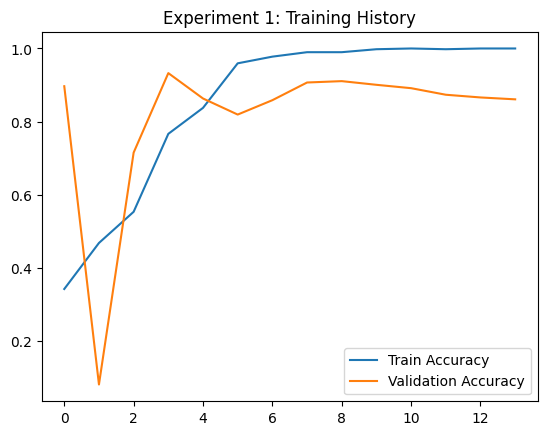

In [25]:
print("\nTF-IDF + Deep Neural Network")

tfidf_exp1 = TfidfVectorizer(max_features=10000) 
X_train_tfidf_exp1 = tfidf_exp1.fit_transform(X_train_oversampled)
X_test_tfidf_exp1 = tfidf_exp1.transform(X_test)

model_exp1 = Sequential([
    Dense(2048, activation='relu', input_shape=(X_train_tfidf_exp1.shape[1],)),
    Dropout(0.7), 
    Dense(1024, activation='relu'), 
    Dropout(0.7), 
    Dense(512, activation='relu'), 
    Dense(3, activation='softmax')
])

model_exp1.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping_exp1 = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Train model
history_exp1 = model_exp1.fit(X_train_tfidf_exp1.toarray(), y_train_oversampled,
                    epochs=500, 
                    batch_size=128,
                    validation_data=(X_test_tfidf_exp1.toarray(), y_test),
                    callbacks=[early_stopping_exp1],
                    verbose=1)

# Evaluasi
train_pred_exp1 = model_exp1.predict(X_train_tfidf_exp1.toarray())
train_acc_exp1 = accuracy_score(y_train_oversampled, np.argmax(train_pred_exp1, axis=1))

test_pred_exp1 = model_exp1.predict(X_test_tfidf_exp1.toarray())
test_acc_exp1 = accuracy_score(y_test, np.argmax(test_pred_exp1, axis=1))

print(f"Training Accuracy (Experiment 1): {train_acc_exp1:.4f}")
print(f"Testing Accuracy (Experiment 1): {test_acc_exp1:.4f}")

print("\nClassification Report (Test Set - Experiment 1):")
print(classification_report(y_test, np.argmax(test_pred_exp1, axis=1)))

print("\nConfusion Matrix (Test Set - Experiment 1):")
print(confusion_matrix(y_test, np.argmax(test_pred_exp1, axis=1)))

plt.plot(history_exp1.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Experiment 1: Training History')
plt.legend()
plt.show()


Word Embeddings + LSTM
Epoch 1/20


/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 17s/step - accuracy: 0.3590 - loss: 1.0833 - val_accuracy: 0.5647 - val_loss: 1.1514
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.6363 - loss: 0.9088 - val_accuracy: 0.8581 - val_loss: 0.4643
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.6157 - loss: 0.8628 - val_accuracy: 0.7204 - val_loss: 0.7651
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.6245 - loss: 0.7867 - val_accuracy: 0.6373 - val_loss: 1.0220
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.6713 - loss: 0.7051 - val_accuracy: 0.8065 - val_loss: 0.4769
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.7811 - loss: 0.5496 - val_accuracy: 0.7567 - val_loss: 0.6277
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.8458 - loss: 0.4325 - val_accuracy: 0.7336 - val_loss: 0.8226
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.9133 - loss: 0.3129 - val_accuracy: 0.8087 - val_loss: 0.5783
Epoch 9/20


/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

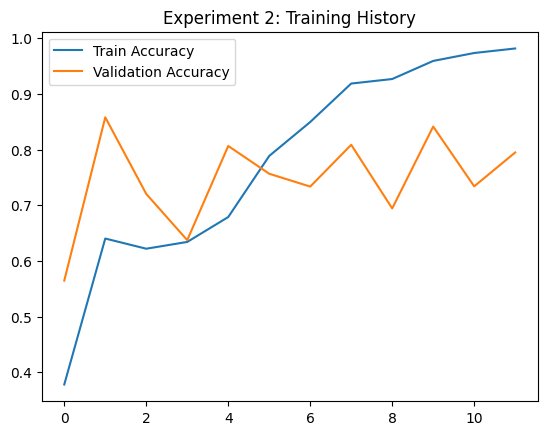

In [27]:
print("\nWord Embeddings + LSTM")

tokenizer_exp2 = Tokenizer(num_words=20000, oov_token="<unk>")
tokenizer_exp2.fit_on_texts(X_train_oversampled)

X_train_seq_exp2 = tokenizer_exp2.texts_to_sequences(X_train_oversampled)
X_test_seq_exp2 = tokenizer_exp2.texts_to_sequences(X_test)

max_len_exp2 = 200
X_train_pad_exp2 = pad_sequences(X_train_seq_exp2, maxlen=max_len_exp2, padding='post', truncating='post')
X_test_pad_exp2 = pad_sequences(X_test_seq_exp2, maxlen=max_len_exp2, padding='post', truncating='post')

model_exp2 = Sequential([
    Embedding(input_dim=20000, output_dim=256, input_length=max_len_exp2),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_exp2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping_exp2 = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Train model
history_exp2 = model_exp2.fit(X_train_pad_exp2, y_train_oversampled,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test_pad_exp2, y_test),
                    callbacks=[early_stopping_exp2],
                    verbose=1)

# Evaluasi
train_pred_exp2 = model_exp2.predict(X_train_pad_exp2)
train_acc_exp2 = accuracy_score(y_train_oversampled, np.argmax(train_pred_exp2, axis=1))

test_pred_exp2 = model_exp2.predict(X_test_pad_exp2)
test_acc_exp2 = accuracy_score(y_test, np.argmax(test_pred_exp2, axis=1))

print(f"Training Accuracy (Experiment 2): {train_acc_exp2:.4f}")
print(f"Testing Accuracy (Experiment 2): {test_acc_exp2:.4f}")

print("\nClassification Report (Test Set - Experiment 2):")
print(classification_report(y_test, np.argmax(test_pred_exp2, axis=1)))

print("\nConfusion Matrix (Test Set - Experiment 2):")
print(confusion_matrix(y_test, np.argmax(test_pred_exp2, axis=1)))

plt.plot(history_exp2.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Experiment 2: Training History')
plt.legend()
plt.show()


TF-IDF + BiLSTM
Epoch 1/500


/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 0.3304 - loss: 1.0984 - val_accuracy: 0.9708 - val_loss: 1.0894
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.4766 - loss: 1.0948 - val_accuracy: 0.9409 - val_loss: 1.0872
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.6798 - loss: 1.0879 - val_accuracy: 0.9477 - val_loss: 1.0696
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.7933 - loss: 1.0707 - val_accuracy: 0.9352 - val_loss: 1.0438
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.9371 - loss: 1.0345 - val_accuracy: 0.9377 - val_loss: 0.9849
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.9480 - loss: 0.9708 - val_accuracy: 0.9222 - val_loss: 0.8990
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.9724 - loss: 0.8578 - val_accuracy: 0.9296 - val_loss: 0.7371
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.9805 - loss: 0.6852 - val_accuracy: 0.9314 - val_loss: 0.5

/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arch/.anaconda3/envs/main-ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

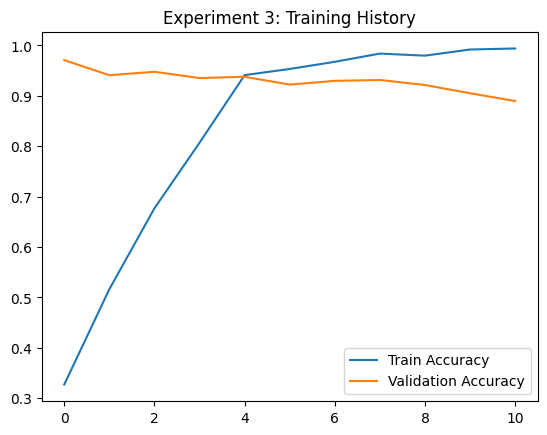

In [28]:
print("\nTF-IDF + BiLSTM")

tfidf_exp3 = TfidfVectorizer(max_features=10000)
X_train_tfidf_exp3 = tfidf_exp3.fit_transform(X_train_oversampled)
X_test_tfidf_exp3 = tfidf_exp3.transform(X_test)

X_train_dense_exp3 = X_train_tfidf_exp3.toarray()
X_test_dense_exp3 = X_test_tfidf_exp3.toarray()

X_train_reshaped_exp3 = X_train_dense_exp3.reshape((X_train_dense_exp3.shape[0], 1, X_train_dense_exp3.shape[1]))
X_test_reshaped_exp3 = X_test_dense_exp3.reshape((X_test_dense_exp3.shape[0], 1, X_test_dense_exp3.shape[1]))

model_exp3 = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(1, X_train_dense_exp3.shape[1])), 
    Dropout(0.5), 
    Bidirectional(LSTM(128)), 
    Dense(256, activation='relu'),
    Dropout(0.5), 
    Dense(3, activation='softmax')
])

model_exp3.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping_exp3 = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Train model
history_exp3 = model_exp3.fit(X_train_reshaped_exp3, y_train_oversampled,
                    epochs=500, 
                    batch_size=128,
                    validation_data=(X_test_reshaped_exp3, y_test),
                    callbacks=[early_stopping_exp3],
                    verbose=1)

# Evaluasi
train_pred_exp3 = model_exp3.predict(X_train_reshaped_exp3)
train_acc_exp3 = accuracy_score(y_train_oversampled, np.argmax(train_pred_exp3, axis=1))

test_pred_exp3 = model_exp3.predict(X_test_reshaped_exp3)
test_acc_exp3 = accuracy_score(y_test, np.argmax(test_pred_exp3, axis=1))

print(f"Training Accuracy (Experiment 3): {train_acc_exp3:.4f}")
print(f"Testing Accuracy (Experiment 3): {test_acc_exp3:.4f}")

print("\nClassification Report (Test Set - Experiment 3):")
print(classification_report(y_test, np.argmax(test_pred_exp3, axis=1)))

print("\nConfusion Matrix (Test Set - Experiment 3):")
print(confusion_matrix(y_test, np.argmax(test_pred_exp3, axis=1)))

plt.plot(history_exp3.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Experiment 3: Training History')
plt.legend()
plt.show()

In [29]:
print("\nRangkuman Akurasi")
print(f"TF-IDF + DNN Testing Accuracy: {test_acc_exp1:.4f}")
print(f"Word Embeddings + LSTM Testing Accuracy: {test_acc_exp2:.4f}")
print(f"TF-IDF + BiLSTM Testing Accuracy: {test_acc_exp3:.4f}")


Rangkuman Akurasi
TF-IDF + DNN Testing Accuracy: 0.9326
Word Embeddings + LSTM Testing Accuracy: 0.8581
TF-IDF + BiLSTM Testing Accuracy: 0.9708


Testing

In [30]:
class_labels = ['negatif', 'netral', 'positif']

def predict_dnn(text):
    """Memprediksi kelas sentimen menggunakan model DNN."""
    text_vectorized = tfidf_exp1.transform([text]).toarray()
    prediction = model_exp1.predict(text_vectorized)
    predicted_class_index = np.argmax(prediction)
    return class_labels[predicted_class_index]

def predict_lstm(text):
    """Memprediksi kelas sentimen menggunakan model LSTM."""
    text_sequence = tokenizer_exp2.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_len_exp2, padding='post', truncating='post')
    prediction = model_exp2.predict(text_padded)
    predicted_class_index = np.argmax(prediction)
    return class_labels[predicted_class_index]

def predict_bilstm(text):
    """Memprediksi kelas sentimen menggunakan model BiLSTM."""
    text_vectorized = tfidf_exp3.transform([text]).toarray()
    text_reshaped = text_vectorized.reshape((text_vectorized.shape[0], 1, text_vectorized.shape[1]))
    prediction = model_exp3.predict(text_reshaped)
    predicted_class_index = np.argmax(prediction)
    return class_labels[predicted_class_index]

In [41]:
new_texts = [
    "sangat kecewa sekali di hp saya lag",
    "aplikasi bagus semoga bisa tangung jawab gak cuma pamer menumenu menjanjikan",
    "akun dana saya tidak bisa dibuka tidak tau kenapa. kira kira kenapa ya?",
    "aplikasi sampah tidak berguna sama sekali sering bermasalah dan gangguan",
    "keren aplikasinya sangat membantu",
    "saya harap kedepannya ada fitur pinjaman online di dana",
]

print("\n--- Inferensi menggunakan TF-IDF + DNN ---")
for text in new_texts:
    prediction = predict_dnn(text)
    print(f"Teks: '{text}' -> Prediksi (DNN): {prediction}")

print("\n--- Inferensi menggunakan Word Embeddings + LSTM ---")
for text in new_texts:
    prediction = predict_lstm(text)
    print(f"Teks: '{text}' -> Prediksi (LSTM): {prediction}")

print("\n--- Inferensi menggunakan TF-IDF + BiLSTM ---")
for text in new_texts:
    prediction = predict_bilstm(text)
    print(f"Teks: '{text}' -> Prediksi (BiLSTM): {prediction}")


--- Inferensi menggunakan TF-IDF + DNN ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Teks: 'sangat kecewa sekali di hp saya lag' -> Prediksi (DNN): negatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Teks: 'aplikasi bagus semoga bisa tangung jawab gak cuma pamer menumenu menjanjikan' -> Prediksi (DNN): positif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Teks: 'akun dana saya tidak bisa dibuka tidak tau kenapa. kira kira kenapa ya?' -> Prediksi (DNN): netral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Teks: 'aplikasi sampah tidak berguna sama sekali sering bermasalah dan gangguan' -> Prediksi (DNN): negatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Teks: 'keren aplikasinya sangat membantu' -> Prediksi (DNN): positif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Teks: 'saya harap kedepannya ada fitur pinjaman online di dana' -> Prediksi (DNN): netral

--- Inferensi menggunakan Word Embeddings + LSTM ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Teks: 'sangat kecewa sekali di hp saya lag' -> Prediksi (LSTM): positif
1/1 ━━━━

## Kesimpulan dan Analisa:


Pengujian model sentimen menunjukkan bahwa TF-IDF + BiLSTM mencapai akurasi yang paling tinggi (97.08%), diikuti TF-IDF + DNN (93.26%) dan Word Embeddings + LSTM (85.81%). Tapi TF-IDF + BiLSTM menunjukkan bias untuk memprediksi "positif" untuk semua teks uji, termasuk teks yang jelas bersentimen negatif. Model TF-IDF + DNN memberikan performa yang lebih seimbang dengan prediksi yang lebih logis sesuai konten teks, walaupun akurasinya sedikit lebih rendah. Sementara itu, Word Embeddings + LSTM juga menunjukkan bias ke arah sentimen positif untuk sebagian besar teks.